# create non eco pedal map

**Author:** binjian Xin<br>
**Date Created:** 2021/07/07<br>
**Last Modified:** 2021/07/07<br>
**Description:** create non-eco pedal map and visualize<br>. But yes.

## Create the non-eco pedal map

read default pedal map (claiming to be eco) from data file

In [43]:
import numpy as np
import pandas as pd

pd_data0 = pd.read_csv("../../data/init_table2.csv", header=0, index_col=0)
# pd_data = pd.DataFrame(pd_data0.values[:,1:], index=pd_data0.values[:,0], columns=pd_data0.columns[1:].to_numpy())
# v = pd_data.to_numpy()
# create a matplotlib 3d figure, //export and save in log
# pd_data0.columns = np.linspace(0, 1.0, num=17)
# pd_data0.index = np.linspace(0, 30, num=21)
# vcu_calib_table_0 = pd_data0.to_numpy()
#
#

In [2]:


# pd_data0 = pd.DataFrame(
#     vcu_calib_table_0,
#     columns=np.linspace(0, 1.0, num=17),
#     index=np.linspace(0, 30, num=21),
# )



## Visualization
### plotly
show default pedal map

### Preliminaries for plotly and chart studio

In [44]:
import plotly.graph_objects as go

# sh_0, sh_1 = pd_data0.shape
# x, y =  np.linspace(0,1.0,sh_1), np.linspace(0,100/3.6, sh_0)
# y[1] = 7/3.6
# x = np.array([0, 2, 4, 8, 12, 16, 20, 24, 28, 32, 38, 44, 50, 62, 74, 86, 100])/100
x = pd_data0.columns.to_numpy()
y = pd_data0.index.to_numpy()
z = pd_data0.values
# # Download data set from plotly repo
# pts = np.loadtxt(np.DataSource().open('https://raw.githubusercontent.com/plotly/datasets/master/mesh_dataset.txt'))
# x, y, z = pts.T
# fig1 = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50)])
# fig1.show()

z0 = np.zeros(z.shape)
figure0 = go.Figure(data=[
                        go.Surface(
                        contours = {
                            "y": {"show": True, "start":0, "end":25, "size":5, "color":"cyan"},
                            "z": {"show": True, "start":-3000, "end":4600, "size":100, "color":"blue"}
                        },
                        x=x,
                        y=y,
                        z=pd_data0.values),
                        go.Surface(x=x,y=y,z=z0)
                        ]
                  )
# figure.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
figure0.update_layout(title='Default Pedal Map', autosize=False,
                     scene=dict(
                         xaxis_title='pedal',
                         yaxis_title='velocity',
                         zaxis_title='torque'),
                     width=700, height=700,
                     margin=dict(l=65,r=50,b=65,t=90))
# figure0.add_trace(go.Surface(x=x,y=y,z=z0, surfacecolor=np.ones(z0.shape)))
figure0.show()
figure0.write_image("table_init.svg", engine="kaleido")

## modify data

Modify default table to generate a non-eco pedal map data array


In [4]:
import chart_studio.plotly as py
# import plotly.graph_objects as graph_objects
import matplotlib.cm as cm
from functools import reduce
import plotly.graph_objects as go

def map_z2color(zval, colormap, vmin, vmax):
    #map the normalized value zval to a corresponding color in the colormap

    if vmin>vmax:
        raise ValueError('incorrect relation between vmin and vmax')
    t=(zval-vmin)/float((vmax-vmin))#normalize val
    R, G, B, alpha=colormap(t)
    return 'rgb('+'{:d}'.format(int(R*255+0.5))+','+'{:d}'.format(int(G*255+0.5))+\
           ','+'{:d}'.format(int(B*255+0.5))+')'


def tri_indices(simplices):
    #simplices is a numpy array defining the simplices of the triangularization
    #returns the lists of indices i, j, k

    return ([triplet[c] for triplet in simplices] for c in range(3))

def plotly_trisurf(x, y, z, simplices, colormap=cm.RdBu, plot_edges=None):
    #x, y, z are lists of coordinates of the triangle vertices
    #simplices are the simplices that define the triangularization;
    #simplices  is a numpy array of shape (no_triangles, 3)
    #insert here the  type check for input data

    points3D=np.vstack((x,y,z)).T
    tri_vertices=map(lambda index: points3D[index], simplices)# vertices of the surface triangles
    zmean=[np.mean(tri[:,2]) for tri in tri_vertices ]# mean values of z-coordinates of
    #triangle vertices
    min_zmean=np.min(zmean)
    max_zmean=np.max(zmean)
    facecolor=[map_z2color(zz,  colormap, min_zmean, max_zmean) for zz in zmean]
    I,J,K=tri_indices(simplices)

    triangles=go.Mesh3d(x=x,
                        y=y,
                        z=z,
                        facecolor=facecolor,
                        i=I,
                        j=J,
                        k=K,
                        name=''
                        )

    if plot_edges is None:# the triangle sides are not plotted
        return [triangles]
    else:
        #define the lists Xe, Ye, Ze, of x, y, resp z coordinates of edge end points for each triangle
        #None separates data corresponding to two consecutive triangles
        lists_coord=[[[T[k%3][c] for k in range(4)]+[ None]   for T in tri_vertices]  for c in range(3)]
        Xe, Ye, Ze=[reduce(lambda x,y: x+y, lists_coord[k]) for k in range(3)]

        #define the lines to be plotted
        lines=go.Scatter3d(x=Xe,
                           y=Ye,
                           z=Ze,
                           mode='lines',
                           line=dict(color= 'rgb(50,50,50)', width=1.5)
                           )
        return [triangles, lines]

### create the planes

In [5]:
# import pyrr
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
import pyrr
# v0 = np.array([1, 0, 4400])
# v1 = np.array([0, 0, 1059])
# v2 = np.array([0, 1.94444, 70])
# v3 = np.array([0, 2.77778, -3200])
# v4 = np.array([0, 27.77778, -3000])
# v5 = np.array([1, 27.77778, 1827])
# v6 = np.array([0.86, 27.77778, 1700])
# v7 = np.array([0.38, 27.77778, 0])
#
# v8 = np.array([1, 11.11111, 4436])
# v9 = np.array([1, 2.77778, 4566])
# v10 = np.array([0.74, 27.77778, 1083])
# v11 = np.array([0.74, 0, 2775])
# v12 = np.array([0.74, 2.77778, 2272])
# v13 = np.array([0.74, 20.83333, 2272])
# points = np.array([v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13])
v0 = np.array([0, 0, 800])
v1 = np.array([0, 7, 80])
v2 = np.array([0, 10, -200])
v3 = np.array([0, 5, -800])
v4 = np.array([0, 20, -800])
v5 = np.array([0, 25, -1300])
v6 = np.array([0, 30, -1300])
v7 = np.array([0, 35, -1500])
v8 = np.array([0, 40, -1400])
v9 = np.array([0, 45, -1800])
v10 = np.array([0, 70, -1800])
v11 = np.array([0, 75, -1600])
v12 = np.array([0, 80, -1400])
v13 = np.array([0, 90, -800])
v14 = np.array([0, 95, -700])
v15 = np.array([0, 100, -600])

v16 = np.array([1, 0, 4436])
v17 = np.array([1, 7, 4526.8])
v18 = np.array([1, 10, 4566.5])
v19 = np.array([1, 20, 4436])
v20 = np.array([1, 35, 4436])
v21 = np.array([1, 40, 4286.7])
v22 = np.array([1, 50, 3625])
v23 = np.array([1, 65, 2651])
v24 = np.array([1, 70, 2674.5])
v25 = np.array([1, 95, 1826])
v26 = np.array([1, 100, 1826.6])

v27 = np.array([0.86, 15, 4426])
v28 = np.array([0.86, 20, 4345])
v29 = np.array([0.86, 25, 4233])
v30 = np.array([0.86, 40, 3915])
v31 = np.array([0.86, 50, 3625])
v32 = np.array([0.86, 55, 3383])

v33 = np.array([0.74, 55, 3018.8])
v34 = np.array([0.74, 65, 2651.2])
v35 = np.array([0.74, 70, 2614.9])
v36 = np.array([0.74, 100, 1668])

v37 = np.array([0.5, 0, 2775])
v38 = np.array([0.38, 0, 2125])
v39 = np.array([0.2, 0, 1150])
v40 = np.array([0.02, 0, 1058.8])

v41 = np.array([0.5, 20, 2427.5])
v42 = np.array([0.5, 55, 1908])
v43 = np.array([0.5, 80, 1429])
v44 = np.array([0.5, 100, 1082.9])

v45 = np.array([0.24, 100, 449])
v46 = np.array([0.2, 100, -36])
v47 = np.array([0.02, 100, -550])
v48 = np.array([0, 100, -600])

v49 = np.array([0.04, 85, -800])
v50 = np.array([0.04, 80, -1000])

v51 = np.array([0.02, 65, -1550])
v52 = np.array([0.02, 45, -1350])
v53 = np.array([0.02, 60, -1450])

points = np.array([v0, v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13,
                   v14, v15, v16, v17, v18, v19, v20, v21, v22, v23, v24, v25, v26, v27,
                   v28, v29, v30, v31, v32, v33, v34, v35, v36, v37, v38, v39, v40, v41,
                   v42, v43, v44, v45, v46, v47, v48, v49, v50, v51, v52, v53])
u = points[:,0]
v = points[:,1]
z = points[:,2]
tri = Delaunay(np.array([u,v]).T)

print('polyhedron(faces = [')
#for vert in tri.triangles:
for vert in tri.simplices:
    print('[%d,%d,%d],' % (vert[0],vert[1],vert[2]),)
print('], points = [')
for i in range(u.shape[0]):
    print ('[%f,%f,%f],' % (u[i], v[i], z[i]),)
print(']);')

print(tri.simplices.shape, '\nShape\n', tri.simplices)


polyhedron(faces = [
[53,10,9],
[18,19,27],
[2,18,27],
[28,19,29],
[19,28,27],
[42,9,31],
[42,53,9],
[3,37,16],
[4,2,27],
[21,52,30],
[52,21,22],
[9,52,31],
[52,22,31],
[8,7,30],
[8,52,9],
[52,8,30],
[6,5,29],
[22,32,31],
[13,49,25],
[49,43,25],
[17,3,16],
[17,1,3],
[28,41,27],
[41,4,27],
[4,41,5],
[5,41,29],
[41,28,29],
[20,6,29],
[19,20,29],
[6,20,7],
[20,21,30],
[7,20,30],
[33,42,31],
[32,33,31],
[42,33,53],
[33,32,53],
[43,24,25],
[13,12,49],
[14,13,25],
[44,14,25],
[26,36,25],
[36,44,25],
[40,3,0],
[40,39,3],
[3,38,37],
[39,38,3],
[23,32,22],
[32,23,53],
[35,11,10],
[11,24,43],
[11,35,24],
[45,14,44],
[53,51,10],
[51,35,10],
[11,50,12],
[50,11,43],
[50,43,49],
[12,50,49],
[45,46,14],
[23,34,53],
[34,51,53],
[51,34,35],
[14,47,15],
[46,47,14],
[1,17,2],
[17,18,2],
[34,23,24],
[35,34,24],
], points = [
[0.000000,0.000000,800.000000],
[0.000000,7.000000,80.000000],
[0.000000,10.000000,-200.000000],
[0.000000,5.000000,-800.000000],
[0.000000,20.000000,-800.000000],
[0.000000,25.000000

In [6]:
axis = dict(
    showbackground=True,
    backgroundcolor="rgb(230, 230,230)",
    gridcolor="rgb(255, 255, 255)",
    zerolinecolor="rgb(255, 255, 255)",
)

layout = go.Layout(
    title='Pedal Map Non-Eco',
    width=800,
    height=800,
    scene=dict(
        xaxis=dict(axis),
        yaxis=dict(axis),
        zaxis=dict(axis),
        aspectratio=dict(
            x=1,
            y=1,
            z=0.5
        ),
    )
)

data1 = plotly_trisurf(points[:,0], points[:,1], points[:,2], tri.simplices, colormap=cm.RdBu, plot_edges=None)



fig2 = go.Figure(data=data1, layout=layout)

# import chart_studio.plotly as py
# from chart_studio.plotly import plot, iplot
from plotly.offline import iplot
iplot(fig2)


## Create meshgrid and data on specified grid

In [7]:
# Generate meshgrid for xy plane

ped = pd_data0.columns.to_numpy().astype(np.float64)
vel = pd_data0.index.to_numpy().astype(np.float64)

pdv, vlv = np.meshgrid(ped, vel, sparse=False)

In [8]:

# find simplices for meshgrid points

p_mesh = np.array(list(zip(pdv, vlv)))
p_mesh_transposed = np.transpose(p_mesh, (0,2,1))

In [23]:
sh_1 = ped.shape[0]
sh_0 = vel.shape[0]
p_mesh_flat = p_mesh_transposed.reshape(sh_0*sh_1, 2, order='A')

In [24]:
p_simplex = tri.find_simplex(p_mesh_flat)


In [25]:
# find barycentric coordinates of the meshgrid points in the corresponding simplices
tri_trans = tri.transform[p_simplex,:2]
tri_r =  tri.transform[p_simplex,2]

p_r = p_mesh_flat - tri_r


In [26]:
b = np.einsum('ijk, ik->ij', tri_trans, p_r)

In [27]:
b3 = 1 - b.sum(axis=1)

In [28]:
barrycentric_p = np.c_[b, b3 ]

In [30]:

tri_vertices = points[tri.simplices]

In [31]:
mesh_faces = tri.simplices[p_simplex]

In [32]:
p_mesh_faces = points[mesh_faces]

In [33]:
# get the z coordinate by using barycentric coordinates of the meshgrid points



# generate 3d meshgrid data

r = np.einsum('ijk,ij->ik', p_mesh_faces, barrycentric_p)


/tmp/ipykernel_25508/2350987410.py:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



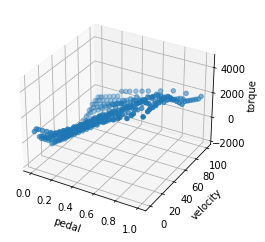

In [34]:
# plot the generated meshgrid as 3d scatter plot
import matplotlib.pyplot as plt
from  mpl_toolkits.mplot3d import Axes3D
fig3 = plt.figure()
ax = fig3.add_subplot(111, projection='3d')

ax.scatter(r[:, 0], r[:,1], r[:,2], marker='o')
ax.set_xlabel('pedal')
ax.set_ylabel('velocity')
ax.set_zlabel('torque')
fig3.show()


In [20]:
# use plotly to plot the 3d data

In [36]:
# sh_0, sh_1 = r.shape
ped = pd_data0.columns.to_numpy().astype(np.float64)
vel = pd_data0.index.to_numpy().astype(np.float64)

# x, y =  np.linspace(0,1.0,sh_1), np.linspace(0,100/3.6, sh_0)
# y[1] = 7/3.6
# x = np.array([0, 2, 4, 8, 12, 16, 20, 24, 28, 32, 38, 44, 50, 62, 74, 86, 100])/100
zr = r[:,2]
zr = zr.reshape(sh_0,sh_1)

In [39]:
# pd_data = pd.DataFrame(pd_data0.values[:,1:], index=pd_data0.values[:,0], columns=pd_data0.columns[1:].to_numpy())
# v = pd_data.to_numpy()
# zr_calib = np.c_[np.arange(17), np.transpose(zr)]
# zr_calib = np.transpose(zr_calib)
zr_calib = pd.DataFrame(zr, index=vel, columns=ped)
zr_calib.to_csv('../../data/14pieces_approx-regen.csv')
# np.savetxt('../../data/14pieces_approx-regen.csv', zr_calib, delimiter=',', fmt='%.1f')


In [50]:
# # Download data set from plotly repo
# pts = np.loadtxt(np.DataSource().open('https://raw.githubusercontent.com/plotly/datasets/master/mesh_dataset.txt'))
# x, y, z = pts.T
# fig1 = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, color='lightpink', opacity=0.50)])
# fig1.show()

z0 = np.zeros(zr.shape)
figure4 = go.Figure(data=[
    go.Surface(
        contours = {
            "y": {"show": True, "start":0, "end":25, "size":5, "color":"cyan"},
            "z": {"show": True, "start":-3000, "end":4600, "size":500, "color":"blue"}
        },
        x=ped,
        y=vel,
        z=zr),
    go.Surface(x=x,y=y,z=z0)
]
)
# figure.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
figure4.update_layout(title='Pedal Map', autosize=False,
                      scene=dict(
                          xaxis_title='pedal',
                          yaxis_title='velocity',
                          zaxis_title='torque'),
                      width=700, height=700,
                      margin=dict(l=65,r=50,b=65,t=90))
# figure0.add_trace(go.Surface(x=x,y=y,z=z0, surfacecolor=np.ones(z0.shape)))
figure4.show()

In [51]:
from src.comm.vcu_calib_generator import generate_vcu_calibration


z0 = np.zeros(zr.shape)
figure5 = go.Figure(data=[
    go.Surface(
        contours = {
            "y": {"show": True, "start":0, "end":25, "size":5, "color":"cyan"},
            "z": {"show": True, "start":-3000, "end":4600, "size":500, "color":"blue"}
        },
        x=ped,
        y=vel,
        z=pd_data0.values),
    go.Surface(x=x,y=y,z=z0)
]
)
# figure.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
figure5.update_layout(title='Original Pedal Map', autosize=False,
                      scene=dict(
                          xaxis_title='pedal',
                          yaxis_title='velocity',
                          zaxis_title='torque'),
                      width=700, height=700,
                      margin=dict(l=65,r=50,b=65,t=90))
# figure0.add_trace(go.Surface(x=x,y=y,z=z0, surfacecolor=np.ones(z0.shape)))
figure5.show()
# pd_data = pd_data0.copy(deep=True)


# Visualization of the DRL found table

In [52]:
import os
last_table_store_path = os.getcwd() + '/../../data/last_table4.csv'
# with open(last_table_store_path, 'rb') as f:
#     z_rl = np.load(f)

pd_data_rl = pd.read_csv("../../data/init_table2.csv", header=0, index_col=0)
# z_rl =

In [57]:
z_diff = pd_data_rl.values - pd_data0.values
figure6 = go.Figure(data=[
    go.Surface(
        contours = {
            "y": {"show": True, "start":0, "end":25, "size":5, "color":"cyan"},
            "z": {"show": True, "start":-3000, "end":4300, "size":500, "color":"blue"}
        },
        x=ped,
        y=vel,
        z=pd_data_rl.values),
    go.Surface(x=x,y=y,z=z0)
]
)
# figure.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
figure6.update_layout(title='Pedal Map by RL', autosize=False,
                      scene=dict(
                          xaxis_title='pedal',
                          yaxis_title='velocity',
                          zaxis_title='torque'),
                      width=700, height=700,
                      margin=dict(l=65,r=50,b=65,t=90))
# figure.add_trace(go.Surface(x=x,y=y,z=z0, surfacecolor=(0,0,0)))
figure6.show()

figure6.write_image("table_rl-regen.svg", engine="kaleido")

visualize the diff table

In [54]:
figure7 = go.Figure(data=[
    go.Surface(
        # contours = {
        #     "y": {"show": True, "start":0, "end":10, "size":0.5, "color":"cyan"},
        #     "z": {"show": True, "start":-400, "end":400, "size":300, "color":"blue"}
        # },
        x=ped,
        y=vel,
        z=z_diff),
]
)
# figure.update_traces(contours_z=dict(show=True, usecolormap=True,
#                                   highlightcolor="limegreen", project_z=True))
figure7.update_layout(title='Diff Pedal Map by RL', autosize=False,
                      scene=dict(
                          xaxis_title='pedal',
                          yaxis_title='velocity',
                          zaxis_title='torque'),
                      width=700, height=700,
                      margin=dict(l=65,r=50,b=65,t=90))
# figure.add_trace(go.Surface(x=x,y=y,z=z0, surfacecolor=(0,0,0)))
figure7.show()

In [ ]:
figure7.write_image("diff-regen.svg", engine="kaleido")

### Create a matplotlib 3d figure

2021-08-17 15:17:07.133075: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


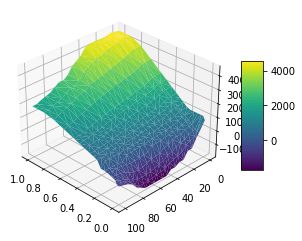

In [55]:
import matplotlib.pyplot as plt
from src.visualization.visual import plot_to_image


df = pd_data0.unstack().reset_index()
df.columns = ["pedal", "velocity", "throttle"]

fig = plt.figure()
ax = plt.axes(projection="3d")
surf = ax.plot_trisurf(
    df["pedal"],
    df["velocity"],
    df["throttle"],
    cmap=plt.cm.viridis,
    linewidth=0.2,
)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 135)

plt.show()


In [ ]:
# from plotly.subplots import make_subplots
# import numpy as np
# figure1 = make_subplots(rows=2, cols=1)
# # download data set from plotly repo
# figure1.append_trace(go.Scatter(
#     x=[3, 4, 5],
#     y=[1000, 1100, 1200],
# ), row=1, col=1)
#
# sh_0, sh_1 = pd_data.shape
# x, y =  np.linspace(0,1.0,sh_1), np.linspace(0,30, sh_0)
# z = pd_data.values
#
# figure1.append_trace(go.Surface(
#     contours = {
#         "y": {"show": True, "start":0, "end":10, "size":1, "color":"cyan"},
#         "z": {"show": True, "start":-3000, "end":4300, "size":300, "color":"blue"}
#     },
#     x=x,
#     y=y,
#     z=pd_data.values),
#     row=2,col=1)
#
# figure1.show()

polyhedron(faces = [
[2,1,0],
[3,2,0],
[2,4,1],
[4,2,3],
], points = [
[0.000000,0.000000,0.000000],
[0.000000,1.000000,0.000000],
[0.500000,0.500000,1.000000],
[1.000000,0.000000,0.000000],
[1.000000,1.000000,0.000000],
]);


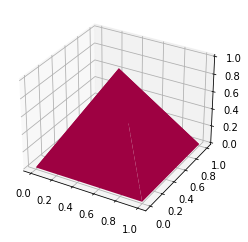

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from scipy.spatial import Delaunay

# u, v are parameterisation variables
u = np.array([0,0,0.5,1,1])
v = np.array([0,1,0.5,0,1])

x = u
y = v
z = np.array([0,0,1,0,0])

# Triangulate parameter space to determine the triangles
#tri = mtri.Triangulation(u, v)
tri = Delaunay(np.array([u,v]).T)

print('polyhedron(faces = [')
#for vert in tri.triangles:
for vert in tri.simplices:
    print('[%d,%d,%d],' % (vert[0],vert[1],vert[2]),)
print('], points = [')
for i in range(x.shape[0]):
    print ('[%f,%f,%f],' % (x[i], y[i], z[i]),)
print(']);')


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# The triangles in parameter space determine which x, y, z points are
# connected by an edge
#ax.plot_trisurf(x, y, z, triangles=tri.triangles, cmap=plt.cm.Spectral)
ax.plot_trisurf(x, y, z, triangles=tri.simplices, cmap=plt.cm.Spectral)


plt.show()

In [ ]:

# # Create the data.
# from numpy import pi, sin, cos, mgrid
# dphi, dtheta = pi/250.0, pi/250.0
# [phi,theta] = mgrid[0:pi+dphi*1.5:dphi,0:2*pi+dtheta*1.5:dtheta]
# m0 = 4; m1 = 3; m2 = 2; m3 = 3; m4 = 6; m5 = 2; m6 = 6; m7 = 4;
# r = sin(m0*phi)**m1 + cos(m2*phi)**m3 + sin(m4*theta)**m5 + cos(m6*theta)**m7
# x = r*sin(phi)*cos(theta)
# y = r*cos(phi)
# z = r*sin(phi)*sin(theta)

# # View it.
# from mayavi import mlab
# s = mlab.mesh(x, y, z)
# mlab.show()